# Imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


## Methods to calculate the size of images before and after compression
The function array_size_mb calculates the size of a numpy array in megabytes. It converts the size from bytes to kilobytes, and then to megabytes.

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

def array_size_mb(arr):
    # Number of bytes
    total_bytes = arr.nbytes
    # Size in kilobytes (KB)
    size_in_kb = total_bytes / 1024
    # Size in megabytes (MB)
    size_in_mb = size_in_kb / 1024
    return size_in_mb


## Prepare the CIFAR10 dataset

This section sets up the CIFAR-10 dataset for training and testing. The transform variable normalizes the images and converts them to PyTorch tensors. The train_dataset and test_dataset variables download the CIFAR-10 dataset, applying the transformations. The train_loader and test_loader variables create data loaders for iterating over the training and test datasets.

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

## Define the AutoEncoder model
This section defines the Autoencoder model using PyTorch. The model consists of an encoder, fully connected layers (bottleneck), and a decoder. The encoder compresses the input image into a latent representation, while the decoder reconstructs the image from this representation.

![Example Image](img/auto-encoder.png)


In [4]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        
        # Fully connected layers to create the bottleneck
        self.fc1 = nn.Linear(392, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 392)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = self.fc2(x)
        x = x.view(x.size(0), 8, 7, 7)  # Reshape
        x = self.decoder(x)
        return x

## Train the model

In [5]:
# Initialize the model, loss function, and optimizer
compression_ratio = 0.9
latent_dim = int(28 * 28 * (1 - compression_ratio))
model = Autoencoder(latent_dim=latent_dim).to(device) 
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Compile and Train the Model
num_epochs = 5

for epoch in range(num_epochs):
    for data in tqdm(train_loader):
        img, _ = data
        img = img.to(device)
        # Forward pass
        output = model(img)
        loss = criterion(output, img)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


100%|██████████| 938/938 [00:05<00:00, 183.24it/s]


Epoch [1/5], Loss: 0.0231


100%|██████████| 938/938 [00:05<00:00, 182.26it/s]


Epoch [2/5], Loss: 0.0125


100%|██████████| 938/938 [00:04<00:00, 190.96it/s]


Epoch [3/5], Loss: 0.0083


100%|██████████| 938/938 [00:05<00:00, 183.39it/s]


Epoch [4/5], Loss: 0.0078


100%|██████████| 938/938 [00:05<00:00, 180.98it/s]

Epoch [5/5], Loss: 0.0068


## Evaluate the model on a single batch and display the results

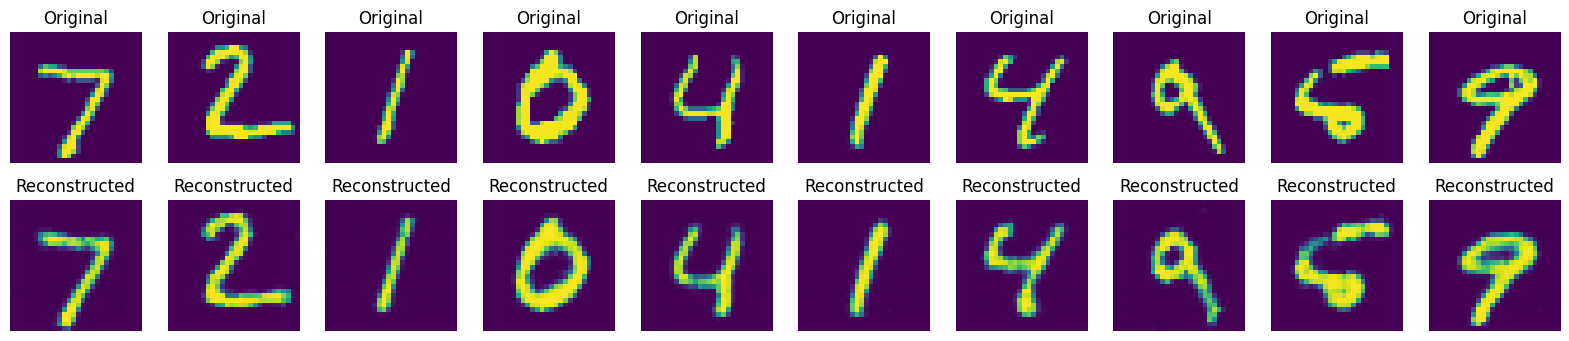

In [6]:
model.eval()

# Get some test images and their reconstructions
dataiter = iter(test_loader)
images, _ = next(dataiter)
images = images.to(device)
output = model(images)

# Move the images back to CPU for visualization
images = images.cpu().detach().numpy()
output = output.cpu().detach().numpy()

# Visualize the results
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i].transpose((1, 2, 0)))
    plt.title("Original")
    plt.axis('off')

    # Display reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(output[i].transpose((1, 2, 0)))
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()

## Compress the images using the encoder and compare the sizes

In [7]:
model.eval()
model.to(device)
compressed_images, original_images = [], []
for images, labels in test_loader:
    images = images.to(device)
    output = model.encoder(images)
    output = model.fc1(output.view(output.size(0), -1))
    original_images.append(images.cpu().detach().numpy())
    compressed_images.append(output.cpu().detach().numpy())

compressed_images = np.array(compressed_images)
original_images = np.array(original_images)


In [8]:
images.shape, output.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64, 78]))

## The compression reduced the size by 90%!

In [9]:
compressed_size = array_size_mb(compressed_images)
original_size = array_size_mb(original_images)

reduction = original_size - compressed_size
percentage = (reduction / original_size) * 100

percentage

90.05102040816327

In [10]:
def plot_all_reconstructed_images(original_images, reconstructed_images, compression_ratios, num_images=5):
    plt.figure(figsize=(15, 2 * len(compression_ratios)))
    count = 1
    for i in range(num_images):
            # Display original images
            ax = plt.subplot(len(compression_ratios) * 2, num_images, count)
            # Adjust image display for a single channel
            plt.imshow(original_images[0][i].squeeze(), cmap='gray')  # Remove singleton dimension and use gray scale
            plt.axis('off')
            count += 1

    for index, dim in enumerate(compression_ratios):
        for i in range(num_images):
            # Display reconstructed images
            ax = plt.subplot(len(compression_ratios) * 2, num_images, count)
            # Adjust image display for a single channel
            plt.imshow(reconstructed_images[index][i].squeeze(), cmap='gray')  # Remove singleton dimension and use gray scale
            plt.axis('off')
            count += 1
            
    plt.suptitle('Original and Reconstructed Images at Different Compression Ratios', fontsize=16)
    plt.show()

## Plot the construction error as a function of compression percentage

In [11]:
# Function to calculate reconstruction error
def calculate_reconstruction_error(model):
    model.eval()
    total_loss = 0
    criterion = nn.MSELoss()
    with torch.no_grad():
        for data in test_loader:
            img, _ = data
            img = img.to(device)
            output = model(img)
            loss = criterion(output, img)
            total_loss += loss.item()
    
    return total_loss / len(test_loader)

# Function to calculate percentage of compression
def calculate_compression_percentage(latent_dim):
    original_size =  28 * 28  # MNIST image size
    compressed_size = latent_dim
    return 100 * (1 - (compressed_size / original_size))

# Hyperparameters
compression_ratios = [0.9, 0.95, 0.99, 0.995]
num_epochs = 5
learning_rate = 0.001
batch_size = 128


# Function to train the model
def train_model(latent_dim):
    model = Autoencoder(latent_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    for epoch in tqdm(range(num_epochs)):
        for data in train_loader:
            img, _ = data
            img = img.to(device)
            # Forward pass
            output = model(img)
            loss = criterion(output, img)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    return model, loss.item()


# Collect data
compression_percentages = []
reconstruction_errors = []

latent_dims = [int(28 * 28 * (1 - ratio)) for ratio in compression_ratios]

# Lists to store images for final plot
all_original_images = []
all_reconstructed_images = []

for latent_dim in latent_dims:
    model, loss = train_model(latent_dim)
    recon_error = calculate_reconstruction_error(model)
    compression_percentage = calculate_compression_percentage(latent_dim)
    
    # Store images for final plot
    original_batch, reconstructed_batch = [], []
    dataiter = iter(test_loader)
    images, _ = next(dataiter)
    images = images[:5].to(device)
    output = model(images)
    
    # Move the images back to CPU for visualization
    original_images = images.cpu().detach().numpy()
    reconstructed_images = output.cpu().detach().numpy()

    all_original_images = [original_images]
    all_reconstructed_images.append(reconstructed_images)
    
    
    compression_percentages.append(compression_percentage)
    reconstruction_errors.append(recon_error)
    print(f'Latent Dim: {latent_dim}, Compression: {compression_percentage:.2f}%, Reconstruction Error: {recon_error:.4f}')
    





100%|██████████| 5/5 [00:23<00:00,  4.72s/it]


Latent Dim: 78, Compression: 90.05%, Reconstruction Error: 0.0053


100%|██████████| 5/5 [00:22<00:00,  4.56s/it]


Latent Dim: 39, Compression: 95.03%, Reconstruction Error: 0.0081


100%|██████████| 5/5 [00:22<00:00,  4.47s/it]


Latent Dim: 7, Compression: 99.11%, Reconstruction Error: 0.0325


100%|██████████| 5/5 [00:23<00:00,  4.64s/it]


Latent Dim: 3, Compression: 99.62%, Reconstruction Error: 0.0479


The following plot shows the effect of increasing the compression ration on the reconstructed images
The rows shows the following:
<ul>
<li>The original image</li>
<li>Reconstructed image after 90% compression</li>
<li>Reconstructed image after 95% compression</li>
<li>Reconstructed image after 99% compression</li>
<li>Reconstructed image after 99.5% compression</li>
</ul>

In the last row, you can start seeing that the model confuses some of the digits with each other. For example, the first image is 7 but the reconstructed images looks like 9

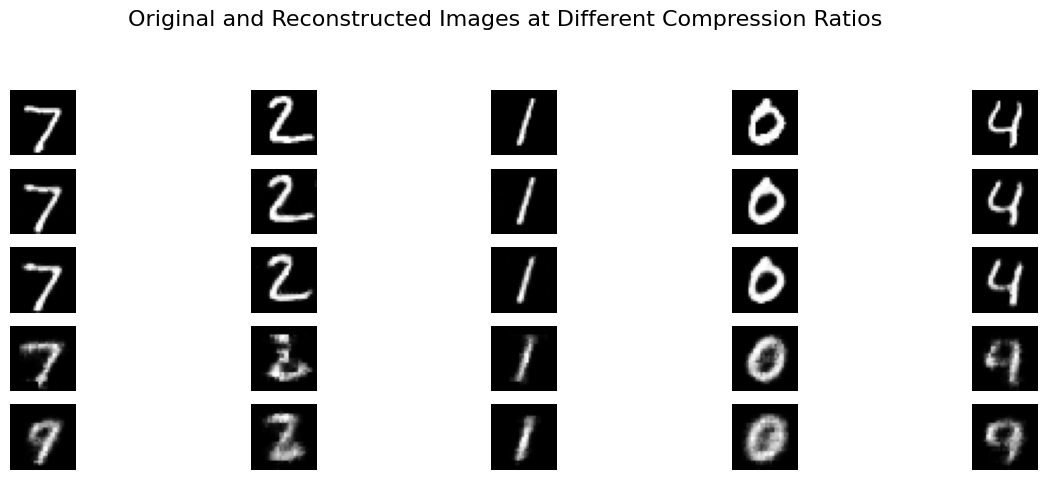

In [12]:
plot_all_reconstructed_images(all_original_images, all_reconstructed_images, compression_ratios)

## The error reconstruction error increases with more compression

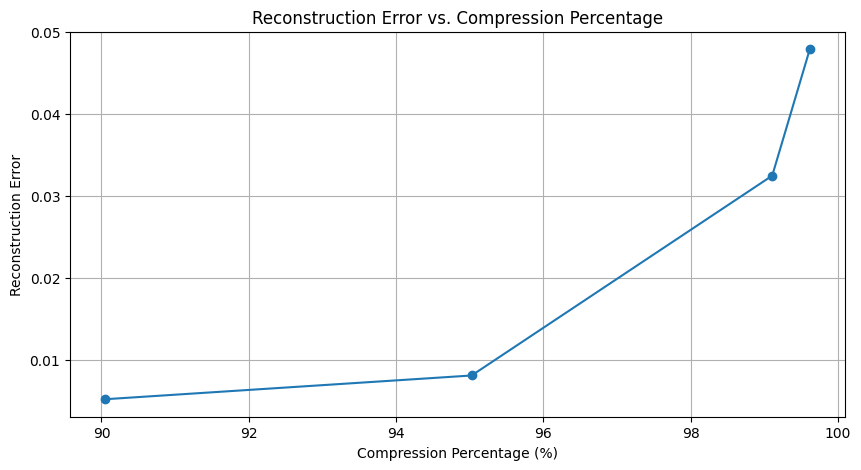

In [13]:
# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(compression_percentages, reconstruction_errors, marker='o')
plt.title('Reconstruction Error vs. Compression Percentage')
plt.xlabel('Compression Percentage (%)')
plt.ylabel('Reconstruction Error')
plt.grid(True)
plt.show()